<a href="https://colab.research.google.com/github/ddlxdd/Computational-Content-Analysis-PsychForum/blob/main/three_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd


flag_df = pd.read_csv("/content/Probe_sheet.csv")

# Path to model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


def sentiment_analysis(text):

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        logits = model(**inputs).logits

    # Apply softmax to logits to get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0].tolist()

    negative = probabilities[0]
    neutral = probabilities[1]
    positive = probabilities[2]

    sentiment_list = ['negative', 'neutral', 'positive']

    # Get the index of the highest probability
    best_sentiment_index = probabilities.index(max(probabilities))


    return {'negative': probabilities[0], 'neutral': probabilities[1], 'positive': probabilities[2], 'best_sentiment': sentiment_list[best_sentiment_index], 'best_sentiment_p':max(probabilities)}

# Analyzing sentiments and storing results
for index, row in flag_df.iterrows():
    comment = str(row["Laura"])
    if comment not in ['[unavailable]','[silent]','[inaudible, sounds like someone could be talking, but no idea what they’re saying]','[inaudible]']:
        sentiment_scores = sentiment_analysis(comment)
        flag_df.at[index, "Negative"] = sentiment_scores['negative']
        flag_df.at[index, "Neutral"] = sentiment_scores['neutral']
        flag_df.at[index, "Positive"] = sentiment_scores['positive']
        flag_df.at[index, "Sentiment(roBERTa)"] = sentiment_scores['best_sentiment']
        flag_df.at[index, "Sentiment probability(roBERTa)"] = sentiment_scores['best_sentiment_p']


flag_df.to_csv('sentiment_flag_roBERTa_24_2_16.csv', index=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sentiment_dict = {}

# Filter out subid values that have NaN in "Let's listen together (0 = no need, 1 = YES)" column
valid_subids = flag_df[flag_df["Let's listen together (0 = no need, 1 = YES)"].notna()]["subid"].unique()

for subid_val in valid_subids:
    sub_df = flag_df[flag_df["subid"] == subid_val]
    positive_count = len(sub_df[sub_df["Sentiment(roBERTa)"] == "positive"])
    negative_count = len(sub_df[sub_df["Sentiment(roBERTa)"] == "negative"])
    neutral_count = len(sub_df[sub_df["Sentiment(roBERTa)"] == "neutral"])
    sentiment_dict[subid_val] = {
        "positive": positive_count,
        "negative": negative_count,
        "neutral": neutral_count
    }

In [ ]:
df_sentiment = pd.DataFrame.from_dict(sentiment_dict, orient='index')

In [ ]:
df_sentiment

,positive,negative,neutral
1,1,0,15
2,0,3,13
3,5,3,24
5,4,5,23
6,0,10,22
7,6,10,16
8,5,6,21
9,6,1,25
10,3,9,20
11,2,6,24


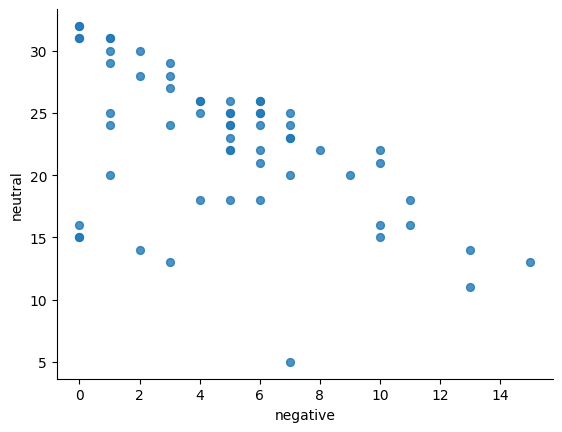

In [ ]:
# @title negative vs neutral

from matplotlib import pyplot as plt
df_sentiment.plot(kind='scatter', x='negative', y='neutral', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

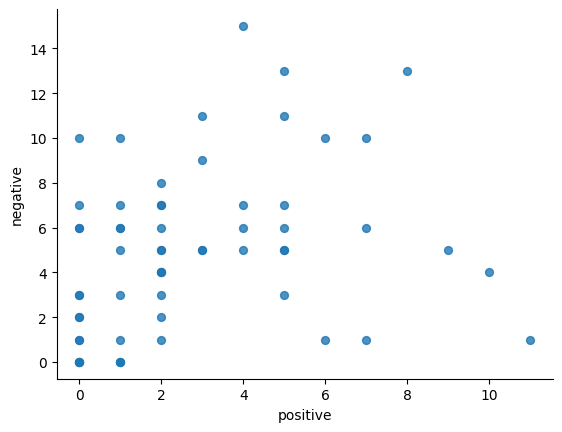

In [ ]:


from matplotlib import pyplot as plt
df_sentiment.plot(kind='scatter', x='positive', y='negative', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

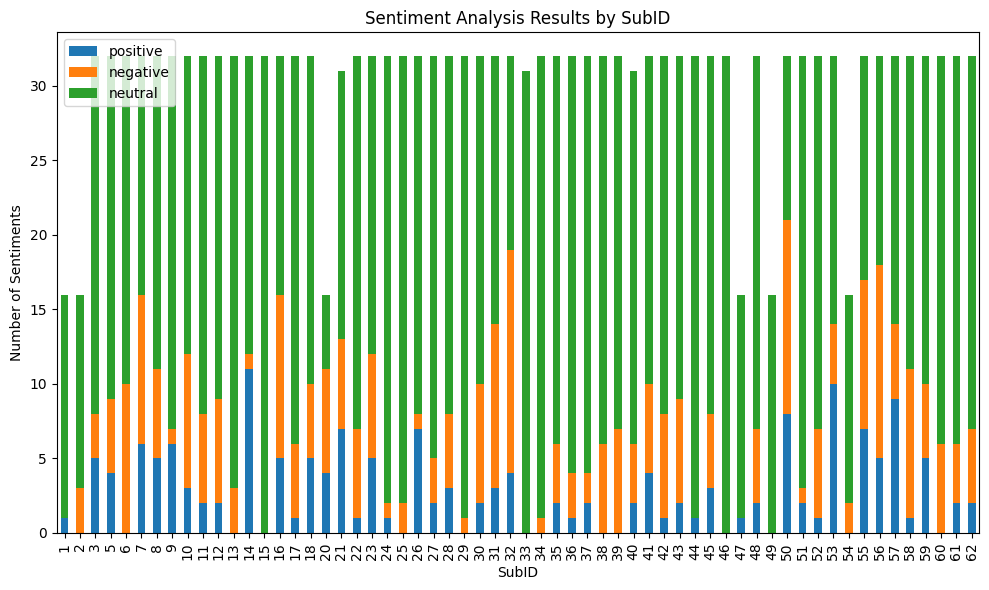

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
df_sentiment.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel("Number of Sentiments")
ax.set_xlabel("SubID")
ax.set_title("Sentiment Analysis Results by SubID")


plt.tight_layout()
plt.show()

In [24]:
flag_df.to_csv('clustered_df.csv', index=False)

In [27]:
flag_df = pd.read_csv('/content/clustered_df.csv', encoding='utf-8')

In [34]:
file_path = '/content/clustered_df.csv'
clustered_df = pd.read_csv(file_path, encoding='ISO-8859-1')


clustered_df['Laura'] = clustered_df['Laura'].str.replace('¡¯', "'", regex=False)

# Filter out rows with '[inaudible]', '[unavailable]', and non-English characters in the 'Laura' column
filtered_df = clustered_df[~clustered_df['Laura'].str.contains(r'\[inaudible]|\[unavailable]|\[silent]', na=False)]
filtered_df = filtered_df[~filtered_df['Laura'].str.contains(r'[^\x00-\x7F]+', na=False)]


sample_size = 50
if len(filtered_df) >= sample_size:
    random_sample = filtered_df['Laura'].sample(n=sample_size, random_state=42).reset_index(drop=True)
else:
    print("Not enough data to sample from after filtering.")


random_sample.to_csv('random_sample.csv', index=False)

In [36]:
hand_labeled_df = pd.read_csv('/content/random_sample_updated.csv')

In [37]:
merged_df = pd.merge(hand_labeled_df, flag_df, on='Laura', how='inner')

In [41]:
merged_df.head()

,Laura,human_rate,subid,session,trial,Taysha,Samantha,Samantha tie breaking notes,"Retriving movie memory? (1 = cake, 2 = north, 3 = pie, 4 = cross, 5 = unknown)",Notes,...,Sentiment probability(roBERTa),Unnamed: 16,Negative,Neutral,Positive_sentiment,Unnamed: 20,PCA1,PCA2,PCA3,Cluster
0,"I was thinking about, uh, how creative I am. O...",neutral,54,1,16,"I was thinking about how creative I am, or if ...",NaN,NaN,NaN,NaN,...,0.502518,NaN,0.038013,0.697260,0.264727,NaN,-0.582658,0.704703,-2.320000e-09,0
1,I was thinking about being able to see my dog ...,neutral,28,2,6,I was thinking about being able to see my dog ...,NaN,NaN,NaN,NaN,...,0.576813,NaN,0.009381,0.539436,0.451183,NaN,-0.061000,1.631323,-7.170000e-08,0
2,I guess I was just wondering about hospitals i...,neutral,53,1,16,I guess I was just wondering about hospitals i...,NaN,NaN,NaN,NaN,...,0.756062,NaN,0.181237,0.793269,0.025494,NaN,-0.654757,-0.591901,-6.480000e-08,0
3,"Uh, I was thinking about the pitch of musical ...",neutral,35,1,1,I was thinking about the pitch of musical inst...,NaN,NaN,NaN,NaN,...,0.800396,NaN,0.063198,0.864670,0.072132,NaN,-1.146108,-0.247988,1.930000e-07,0
4,"Thinking about Milka chocolate bars. You know,...",neutral,21,1,3,"Thinking about milk and chocolate bars, with t...",Thinking about Milka chocolate bars. With the ...,Laura,NaN,NaN,...,0.605841,NaN,0.027326,0.757072,0.215602,NaN,-0.822339,0.479005,-6.680000e-08,0


In [43]:
from sklearn.metrics import accuracy_score

merged_df = merged_df.dropna(subset=['human_rate', 'Sentiment(roBERTa)'])

# Convert to categorical with consistent categories
categories = ['negative', 'neutral', 'positive']
merged_df['human_rate'] = pd.Categorical(merged_df['human_rate'], categories=categories)
merged_df['Sentiment(roBERTa)'] = pd.Categorical(merged_df['Sentiment(roBERTa)'], categories=categories)

# Calculate accuracy manually
correct_predictions = (merged_df['human_rate'] == merged_df['Sentiment(roBERTa)']).sum()
total_predictions = len(merged_df)
accuracy = correct_predictions / total_predictions

print(f"Accuracy of the roBERTa sentiment analysis model: {accuracy:.2%}")


Accuracy of the roBERTa sentiment analysis model: 81.25%


In [ ]:
flag_df.to_excel('sentiment_flag_roBERTa_23127.xlsx', index=False)

In [2]:
import pandas as pd

# Try using a different encoding such as 'ISO-8859-1' or 'Windows-1252'
try:
    flag_df = pd.read_csv('/content/clustered_df.csv', encoding='ISO-8859-1')
except UnicodeDecodeError:
    flag_df = pd.read_csv('/content/clustered_df.csv', encoding='Windows-1252')



In [3]:
flag_df

,subid,session,trial,Taysha,Laura,Samantha,Samantha tie breaking notes,"Retriving movie memory? (1 = cake, 2 = north, 3 = pie, 4 = cross, 5 = unknown)",Notes,Xiaochen (transcription differences),...,Sentiment probability(roBERTa),Unnamed: 16,Negative,Neutral,Positive,Unnamed: 20,PCA1,PCA2,PCA3,Cluster
0,1,1,1,I was thinking about baking a pie¡­[inaudible],I was thinking about baking a pie¡­[inaudible],NaN,NaN,NaN,NaN,[],...,0.621768,NaN,0.011975,0.881989,0.106036,-0.167942,-1.309330,-0.032955,7.900000e-08,0
1,1,1,2,[inaudible],I was thinking about...[inaudible],NaN,NaN,NaN,NaN,['[inaudible]/i was thinking about...[inaudibl...,...,0.675962,NaN,0.041050,0.923291,0.035659,-0.563324,-1.403775,-0.401182,2.090000e-07,0
2,1,1,3,I¡¯m thinking about this amazing cherry pie......,I was thinking about this amazing cherry pie t...,I was thinking about this amazing cherry pie t...,neither,NaN,NaN,"[""i'm/i was"", 'pie.. [inaudible maybe ¡°making...",...,0.615510,NaN,0.003280,0.034335,0.962386,-0.719895,1.775250,4.098603,6.500000e-08,2
3,1,1,4,"Family...[inaudible, sounded like they maybe s...","I was thinking about my family, specifically.....","I was thinking about my family, specifically.....",matched both - still couldn't understand last ...,NaN,NaN,['family...[inaudible sounded like they maybe ...,...,0.704368,NaN,0.069364,0.877701,0.052935,NaN,-1.181770,-0.346646,-1.040000e-07,0
4,1,1,5,I'm thinking about...Curtis...next week...[ina...,I was thinking about my boyfriend Curtis who i...,I was thinking about my boyfriend Curtis who i...,Laura,NaN,NaN,"[""i'm/i was"", 'about...curtis...next week...[i...",...,0.542363,NaN,0.013964,0.770773,0.215263,NaN,-0.898517,0.490889,-1.190000e-07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,62,2,12,I¡¯m thinking about going back home this winte...,I¡¯m thinking about go back home this winter b...,NaN,NaN,NaN,NaN,"['going/go', 'want to each/must eat']",...,NaN,NaN,0.003656,0.053026,0.943318,NaN,1.707593,4.006425,1.930000e-07,2
1884,62,2,13,"I¡¯m thinking about my internship this summer,...",I¡¯m thinking about my internship this summer ...,NaN,NaN,NaN,NaN,[],...,NaN,NaN,0.049004,0.843342,0.107655,NaN,-1.095740,-0.062614,3.930000e-09,0
1885,62,2,14,I¡¯m thinking about going to watch...[inaudibl...,"I¡¯m thinking about, um, going to Washington D...",NaN,NaN,NaN,NaN,['watch...[inaudible] in/washington d.c to um'],...,NaN,NaN,0.005523,0.677208,0.317269,NaN,-0.572621,0.990518,-2.950000e-08,0
1886,62,2,15,I¡¯m thinking about the Korean movie names Squ...,I¡¯m thinking about the Korean movie named ¡®S...,NaN,NaN,NaN,NaN,"[""names squid games that/named ¡®sweet jane'""]",...,NaN,NaN,0.023788,0.736289,0.239923,NaN,-0.753190,0.599674,8.220000e-08,0


In [4]:
rating = pd.read_csv('/content/all_ratings_new.csv')
rating.head()

,Unnamed: 0,Sub,Ses,Run,Awake,External,Future,Past,Other,Positive,Image,Word,Detail
0,0,1001,1,1,"['8', '8', '8', '8', '8', '8', '8', '8']","['7', '8', '3', '2', '2', '3', '2', '2']","['2', '2', '1', '6', '8', '3', '7', '3']","['8', '3', '9', '3', '2', '8', '2', '3']","['3', '3', '7', '9', '2', '7', '2', '9']","['5', '5', '7', '5', '4', '7', '6', '3']","['4', '3', '8', '6', '3', '9', '4', '4']","['4', '4', '2', '8', '8', '1', '7', '4']","['8', '7', '7', '3', '8', '7', '3', '2']"
1,1,1001,1,2,"['8', '8', '8', '8', '8', '8', '8', '8']","['6', '3', '3', '2', '2', '2', '2', '2']","['3', '3', '2', '3', '4', '1', '7', '9']","['7', '7', '8', '7', '8', '9', '2', '1']","['8', '2', '2', '6', '7', '1', '4', '7']","['4', '4', '4', '8', '3', '5', '8', '8']","['7', '6', '8', '9', '3', '6', '9', '7']","['3', '3', '1', '1', '7', '3', '1', '3']","['8', '2', '4', '8', '6', '2', '4', '3']"
2,2,1002,1,1,"['8', '8', '7', '8', '8', '7', '7', '8']","['8', '5', '7', '2', '3', '7', '7', '8']","['2', '2', '7', '8', '7', '7', '7', '2']","['1', '2', '2', '7', '6', '1', '1', '2']","['5', '5', '5', '3', '3', '4', '4', '2']","['5', '3', '5', '5', '5', '6', '6', '4']","['7', '5', '5', '4', '6', '6', '4', '2']","['8', '5', '6', '6', '6', '6', '7', '7']","['3', '3', '4', '4', '4', '6', '4', '6']"
3,3,1002,1,2,"['8', '8', '9', '9', '9', '9', '9', '9']","['8', '6', '6', '9', '1', '2', '9', '9']","['3', '8', '8', '6', '1', '4', '5', '6']","['1', '1', '3', '2', '8', '2', '5', '5']","['8', '2', '3', '1', '6', '6', '4', '4']","['5', '6', '5', '3', '5', '6', '3', '4']","['3', '7', '7', '2', '8', '6', '5', '5']","['6', '7', '6', '2', '4', '6', '5', '5']","['4', '7', '7', '6', '6', '6', '5', '5']"
4,4,1003,1,1,"['6', '7', '6', '6', '7', '7', '7', '7']","['4', '7', '6', '7', '6', '3', '4', '8']","['3', '4', '4', '4', '6', '7', '5', '4']","['3', '6', '4', '6', '6', '6', '6', '6']","['2', '1', '3', '7', '5', '4', '6', '3']","['6', '4', '4', '5', '5', '5', '5', '4']","['4', '3', '3', '3', '2', '2', '2', '1']","['6', '7', '6', '7', '8', '9', '8', '6']","['1', '1', '1', '4', '6', '6', '7', '7']"


In [5]:
sample_flag = flag_df


In [6]:
sentiment = {}
for index_rating, row_rating in rating.iterrows():
    # Calculate the corresponding subid in sample_flag
    corresponding_subid = row_rating['Sub'] - 1000

    # Iterate over the sample_flag dataframe
    for index_flag, row_flag in sample_flag.iterrows():
        subid = row_flag['subid']
        session = row_flag['session']

        # Check if the subid from sample_flag matches the corresponding subid
        if subid == corresponding_subid and row_rating["Ses"] == session:
            # Initialize subid in sentiment dictionary if not present
            if subid not in sentiment:
                sentiment[subid] = {}

            # Initialize session in sentiment[subid] dictionary if not present
            if session not in sentiment[subid]:
                sentiment[subid][session] = {'negative': [], 'neutral': [], 'positive': []}

            # Append the sentiment scores
            sentiment[subid][session]['negative'].append(row_flag['Negative'])
            sentiment[subid][session]['neutral'].append(row_flag['Neutral'])
            sentiment[subid][session]['positive'].append(row_flag['Positive'])



In [7]:
import ast

positive_scores_rating = {}

for index, row in rating.iterrows():
    sub = row['Sub']
    session = row['Ses']
    # Convert the string representation of the list to an actual list
    positive_score = ast.literal_eval(row['Positive']) if isinstance(row['Positive'], str) else row['Positive']

    if sub not in positive_scores_rating:
        positive_scores_rating[sub] = {}

    if session not in positive_scores_rating[sub]:
        positive_scores_rating[sub][session] = []

    # Extend the list with the new scores
    positive_scores_rating[sub][session].extend(positive_score)

# Flatten the lists within each session
for sub in positive_scores_rating:
    for session in positive_scores_rating[sub]:
        # Merge the lists into a single list
        positive_scores_rating[sub][session] = [score for sublist in positive_scores_rating[sub][session] for score in sublist]


In [ ]:
behavior_score = positive_scores_rating[1001][1]
behavior_score

['5',
 '5',
 '7',
 '5',
 '4',
 '7',
 '6',
 '3',
 '4',
 '4',
 '4',
 '8',
 '3',
 '5',
 '8',
 '8']

In [ ]:
negative_score = sentiment[1][1]['negative'][0:16]

In [ ]:
correlation, p_value = spearmanr(negative_score, behavior_score)
correlation, p_value

(0.14995352161133443, 0.5793675426463759)

In [8]:
from scipy.stats import spearmanr

def calculate_correlations(behavior_scores, sentiment_scores):
    correlations = {}

    # Iterate through each participant in behavior_scores
    for sub in behavior_scores:
        adjusted_sub = sub - 1000
        correlations[sub] = {}

        # Iterate through each session for the participant
        for session in behavior_scores[sub]:
            correlations[sub][session] = {}


            if adjusted_sub in sentiment_scores and session in sentiment_scores[adjusted_sub]:
                for sentiment_type in ['negative', 'neutral', 'positive']:
                    # Check if sentiment data is available
                    if sentiment_type in sentiment_scores[adjusted_sub][session]:

                        behavior = [int(score) for score in behavior_scores[sub][session]]
                        sentiment = [float(score) for score in sentiment_scores[adjusted_sub][session][sentiment_type]]

                        # Ensure the lists have the same length
                        min_length = min(len(behavior), len(sentiment))
                        if min_length > 0:
                            behavior = behavior[:min_length]
                            sentiment = sentiment[:min_length]

                            # Calculate Spearman correlation
                            correlation, p_value = spearmanr(sentiment, behavior)
                            correlations[sub][session][sentiment_type] = {'correlation': correlation, 'p_value': p_value}


    return correlations

# Example usage
correlation_results = calculate_correlations(positive_scores_rating, sentiment)

# Print or process the results
print(correlation_results)


{1001: {1: {'negative': {'correlation': 0.14995352161133443, 'p_value': 0.5793675426463759}, 'neutral': {'correlation': -0.08547350731846061, 'p_value': 0.7529615849275992}, 'positive': {'correlation': -0.0644800142928738, 'p_value': 0.8124674260494529}}}, 1002: {1: {'negative': {'correlation': -0.8049458340832496, 'p_value': 0.00016900976587017717}, 'neutral': {'correlation': 0.637119289525352, 'p_value': 0.00794398437668445}, 'positive': {'correlation': 0.29991225092290963, 'p_value': 0.25908261024919044}}}, 1003: {1: {'negative': {'correlation': -0.1301582746911937, 'p_value': 0.6309052485775127}, 'neutral': {'correlation': 0.3145491638370514, 'p_value': 0.2354042155526237}, 'positive': {'correlation': -0.016269784336399213, 'p_value': 0.9523122006406062}}, 2: {'negative': {'correlation': -0.5533449720395175, 'p_value': 0.026182158129239387}, 'neutral': {'correlation': -0.5483896439317009, 'p_value': 0.027841933597719318}, 'positive': {'correlation': 0.594639372937989, 'p_value': 0.

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [ ]:
pip install pandas openpyxl

In [ ]:
import pandas as pd

df = pd.DataFrame(correlation_results)

# Specify the Excel file name
excel_file = "correlation_result.xlsx"

# Writing to Excel
df.to_excel(excel_file, index=False)

In [ ]:
import json

# Load correlation_results from a JSON file
with open('correlation_results.json', 'r') as file:
    correlation_results = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'correlation_results.json'

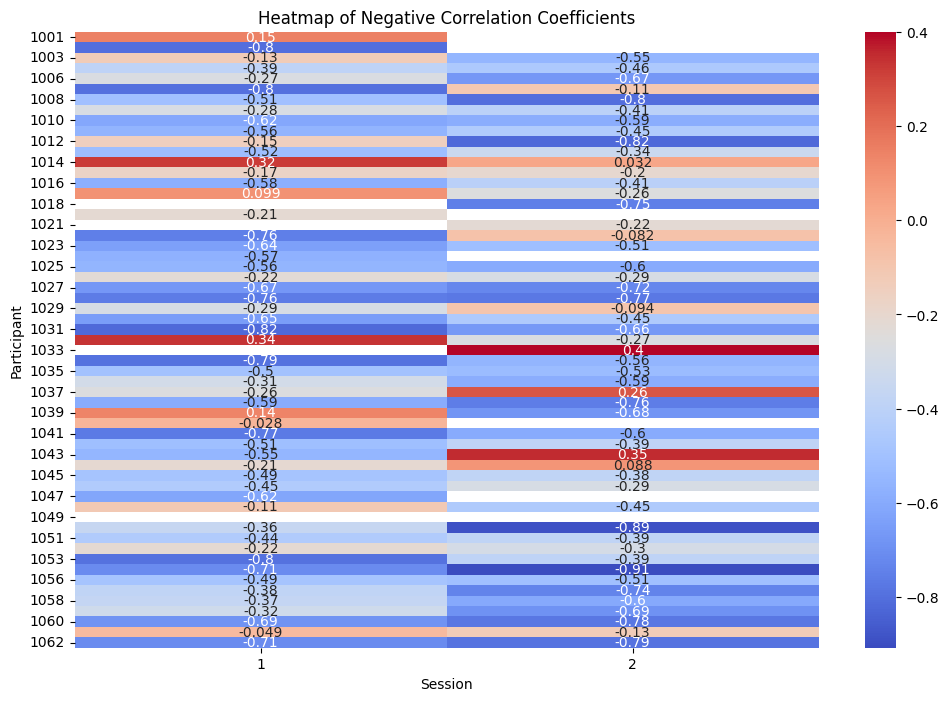

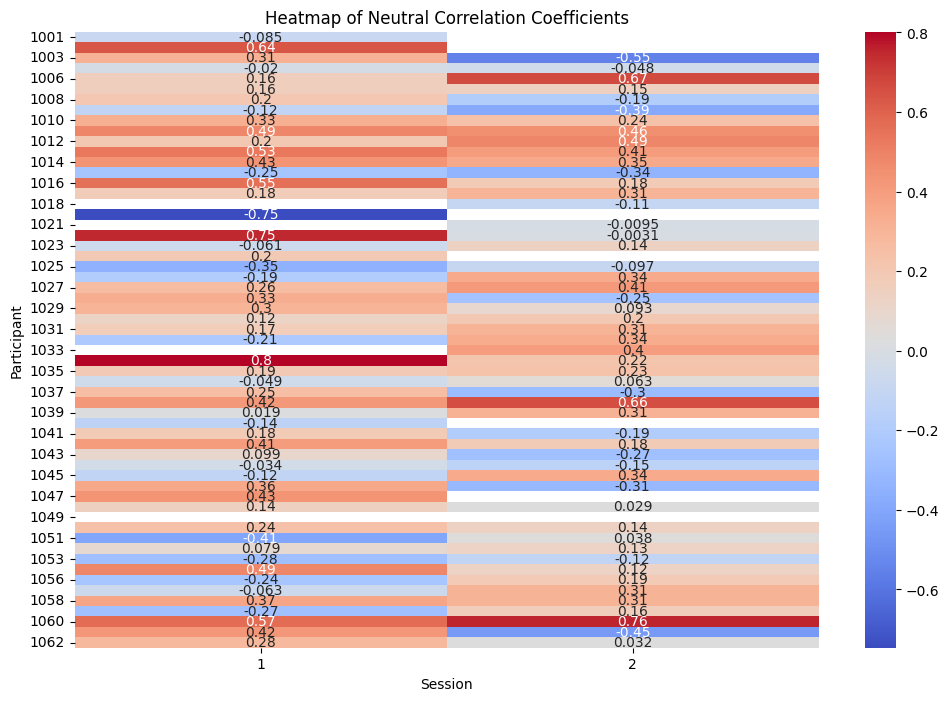

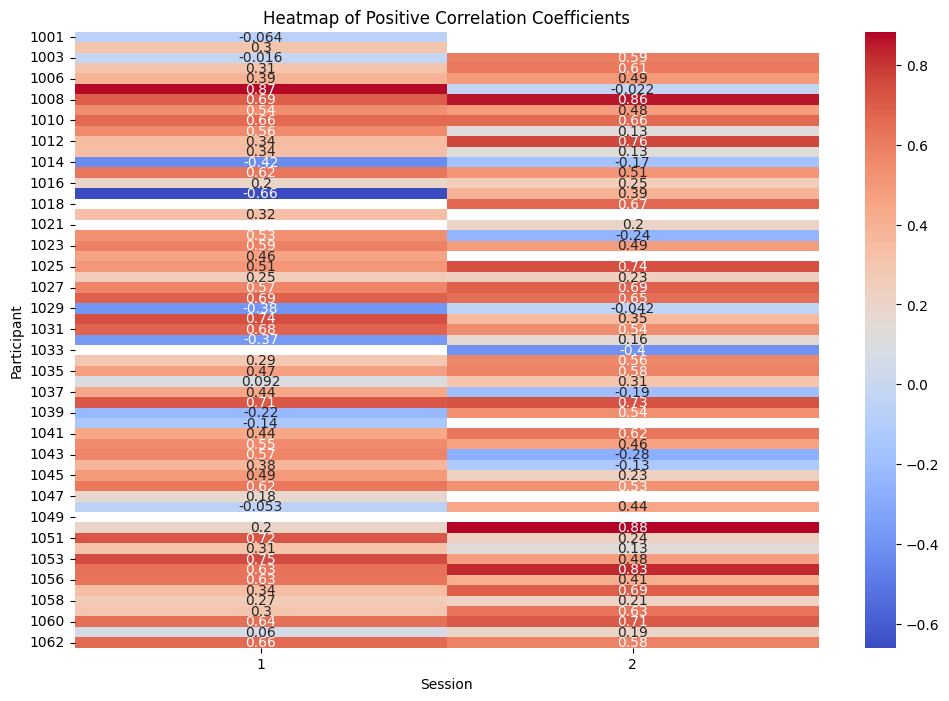

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_heatmap_for_sentiment_type(df, sentiment_type):
    # Filter the DataFrame for the sentiment type
    df_filtered = df[df['Sentiment Type'] == sentiment_type]

    # Create a pivot table for the heatmap
    pivot_table = df_filtered.pivot(index='Participant', columns='Session', values='Correlation')

    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap="coolwarm")
    plt.title(f'Heatmap of {sentiment_type.capitalize()} Correlation Coefficients')
    plt.show()


data_for_heatmap = []

for sub in correlation_results:
    for session in correlation_results[sub]:
        for sentiment_type in ['negative', 'neutral', 'positive']:
            # Check if sentiment type exists in the session data
            if sentiment_type in correlation_results[sub][session]:
                if 'correlation' in correlation_results[sub][session][sentiment_type]:
                    correlation = correlation_results[sub][session][sentiment_type]['correlation']
                    if correlation is not None:
                        data_for_heatmap.append({'Participant': sub, 'Session': session, 'Correlation': correlation, 'Sentiment Type': sentiment_type})

df = pd.DataFrame(data_for_heatmap)

# Create separate heatmaps for each sentiment type
for sentiment_type in ['negative', 'neutral', 'positive']:
    create_heatmap_for_sentiment_type(df, sentiment_type)

In [1]:
import pandas as pd
import ast
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
for col in ['Awake', 'External', 'Future', 'Past', 'Other', 'Positive', 'Image', 'Word', 'Detail']:
    rating[col] = rating[col].apply(ast.literal_eval)  # Convert to list
    rating[col] = rating[col].apply(lambda x: np.mean([int(i) for i in x if i.isdigit()]))  # Average the list

In [7]:
rating

,Unnamed: 0,Sub,Ses,Run,Awake,External,Future,Past,Other,Positive,Image,Word,Detail
0,0,1001,1,1,8.000,3.625,4.000,4.750,5.250,5.250,5.125,4.750,5.625
1,1,1001,1,2,8.000,2.750,4.000,6.125,4.625,5.500,6.875,2.750,4.625
2,2,1002,1,1,7.625,5.875,5.250,2.750,3.875,4.875,4.875,6.375,4.250
3,3,1002,1,2,8.750,6.250,5.125,3.375,4.250,4.625,5.375,5.125,5.750
4,4,1003,1,1,6.625,5.625,4.625,5.375,3.875,4.750,2.500,7.125,4.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,225,1061,2,2,5.250,3.625,3.625,5.250,2.875,5.125,3.000,5.250,2.750
226,226,1062,1,1,5.750,4.125,5.500,4.125,5.625,5.875,6.875,3.500,4.750
227,227,1062,1,2,5.875,4.000,5.250,4.875,4.000,5.375,6.250,4.625,5.250
228,228,1062,2,1,5.625,3.125,4.875,4.625,4.625,5.500,6.125,4.625,5.125


In [8]:
rating['Adjusted_Sub'] = rating['Sub'] - 1000

In [9]:
flag_df.rename(columns={'Positive': 'Positive_sentiment'}, inplace=True)

In [10]:
merged_df = pd.merge(
    flag_df,
    rating,
    left_on=['subid', 'session'],
    right_on=['Adjusted_Sub', 'Ses']
)

In [11]:
merged_df.head()

,subid,session,trial,Taysha,Laura,Samantha,Samantha tie breaking notes,"Retriving movie memory? (1 = cake, 2 = north, 3 = pie, 4 = cross, 5 = unknown)",Notes,Xiaochen (transcription differences),...,Awake,External,Future,Past,Other,Positive,Image,Word,Detail,Adjusted_Sub
0,1,1,1,I was thinking about baking a pie¡­[inaudible],I was thinking about baking a pie¡­[inaudible],NaN,NaN,NaN,NaN,[],...,8.0,3.625,4.0,4.750,5.250,5.25,5.125,4.75,5.625,1
1,1,1,1,I was thinking about baking a pie¡­[inaudible],I was thinking about baking a pie¡­[inaudible],NaN,NaN,NaN,NaN,[],...,8.0,2.750,4.0,6.125,4.625,5.50,6.875,2.75,4.625,1
2,1,1,2,[inaudible],I was thinking about...[inaudible],NaN,NaN,NaN,NaN,['[inaudible]/i was thinking about...[inaudibl...,...,8.0,3.625,4.0,4.750,5.250,5.25,5.125,4.75,5.625,1
3,1,1,2,[inaudible],I was thinking about...[inaudible],NaN,NaN,NaN,NaN,['[inaudible]/i was thinking about...[inaudibl...,...,8.0,2.750,4.0,6.125,4.625,5.50,6.875,2.75,4.625,1
4,1,1,3,I¡¯m thinking about this amazing cherry pie......,I was thinking about this amazing cherry pie t...,I was thinking about this amazing cherry pie t...,neither,NaN,NaN,"[""i'm/i was"", 'pie.. [inaudible maybe ¡°making...",...,8.0,3.625,4.0,4.750,5.250,5.25,5.125,4.75,5.625,1


In [13]:
correlation_results

""


<ipython-input-14-6ce629f2857b>:24: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = correlation_results.pivot("Question", "Sentiment", "Correlation")


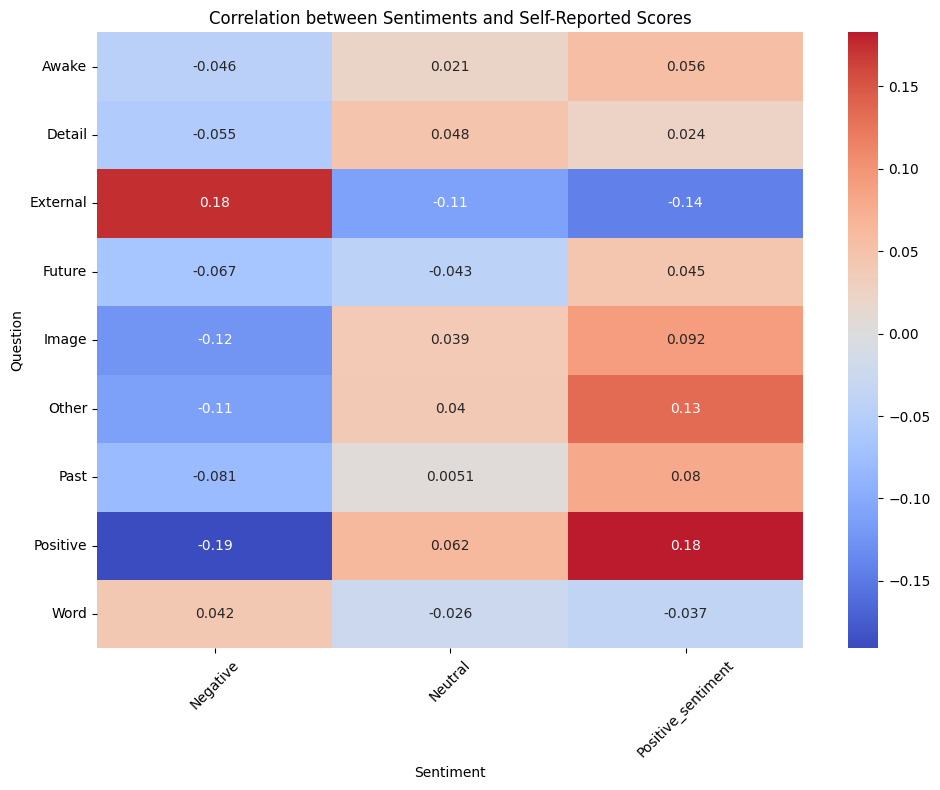

In [14]:
correlation_results = pd.DataFrame()

# List all the questions you want to correlate with
questions = ['Awake', 'External', 'Future', 'Past', 'Other', 'Positive', 'Image', 'Word', 'Detail']

# Calculate the correlation for each sentiment against each question's score
for question in questions:
    for sentiment in ['Negative', 'Neutral', 'Positive_sentiment']:  # Use the correct sentiment column names
        # Make sure to drop NaN values to calculate the correlation properly
        valid_indices = merged_df[[sentiment, question]].dropna().index
        corr, p_value = spearmanr(merged_df.loc[valid_indices, sentiment],
                                  merged_df.loc[valid_indices, question],
                                  nan_policy='omit')
        # Append the results to the correlation_results DataFrame using pd.concat instead of .append()
        new_row = pd.DataFrame({
            'Sentiment': [sentiment],
            'Question': [question],
            'Correlation': [corr],
            'P-Value': [p_value]
        })
        correlation_results = pd.concat([correlation_results, new_row], ignore_index=True)

# Create a heatmap using the correlation results
heatmap_data = correlation_results.pivot("Question", "Sentiment", "Correlation")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Sentiments and Self-Reported Scores')
plt.xticks(rotation=45)  # Improve readability of x-axis labels
plt.yticks(rotation=0)  # Keep the y-axis labels horizontal
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

In [16]:
heatmap_data.to_csv('heatmap_data.csv')

In [ ]:
import numpy as np

def fisher_z_transform(r):
    return np.arctanh(r)

def inverse_fisher_z_transform(z):
    return np.tanh(z)

# Apply Fisher z transformation to each correlation coefficient
df['Fisher_z'] = df['Correlation'].apply(fisher_z_transform)

In [ ]:
# Group the data and calculate the mean Fisher z for each group
grouped_data = df.groupby(['Participant', 'Sentiment Type'])['Fisher_z'].mean().reset_index()

# Apply the inverse Fisher z transformation to get the mean correlation coefficients
grouped_data['Mean_Correlation'] = grouped_data['Fisher_z'].apply(inverse_fisher_z_transform)

In [ ]:
pca_data = grouped_data.pivot(index='Participant', columns='Sentiment Type', values='Mean_Correlation')

In [ ]:
pca_data.head()

Sentiment Type,negative,neutral,positive
Participant,,,
1001,0.220432,-0.110966,-0.065980
1002,-0.607594,0.478616,0.402473
1003,-0.466805,-0.104776,0.409990
1005,-0.361640,0.067833,0.177427
1006,-0.590393,0.686000,0.358963


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Replace NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(scaled_data)

# Apply PCA to the imputed data
pca = PCA(n_components=3)
pca_result = pca.fit_transform(imputed_data)


pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2', 'PCA3'])

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio of each component:", explained_variance_ratio)

Explained variance ratio of each component: [0.655027   0.30448857 0.04048442]


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
cluster_labels = kmeans.fit_predict(pca_df)

pca_df['Cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
pca_df.head()

,PCA1,PCA2,PCA3,Cluster
0,3.276204,0.090338,0.536867,2
1,-1.212948,-0.866781,-0.115965,0
2,0.104172,1.164016,-0.389494,1
3,0.701547,0.076939,-0.425755,1
4,-1.385612,-1.684629,0.086791,0


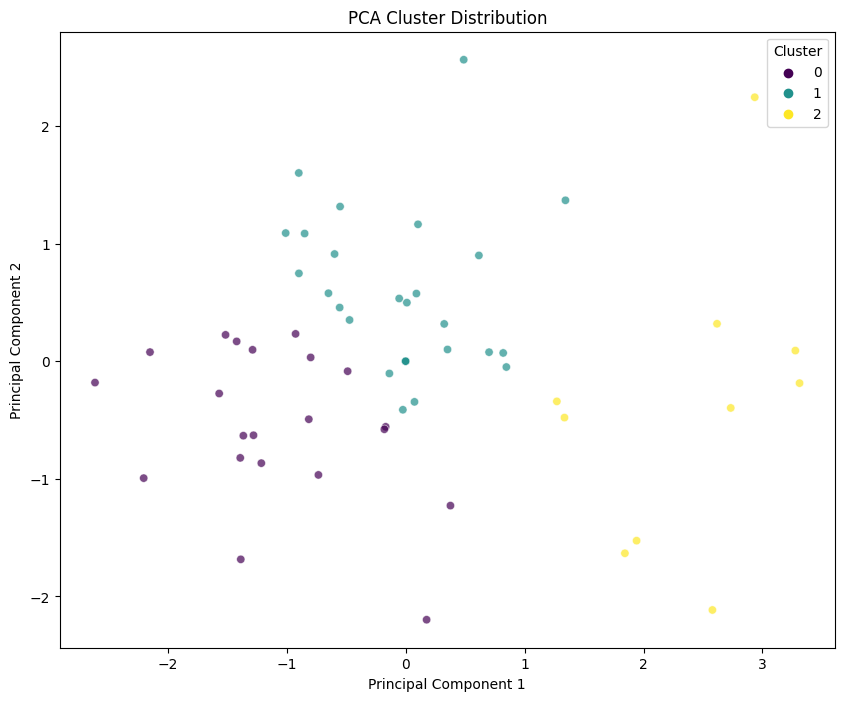

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title('PCA Cluster Distribution')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [ ]:
loadings = pca.components_
print("PCA Loadings:\n", loadings)

PCA Loadings:
 [[ 0.68934675 -0.39112186 -0.60977434]
 [-0.05569502 -0.86785029  0.49369417]
 [ 0.72228742  0.30636507  0.62003332]]


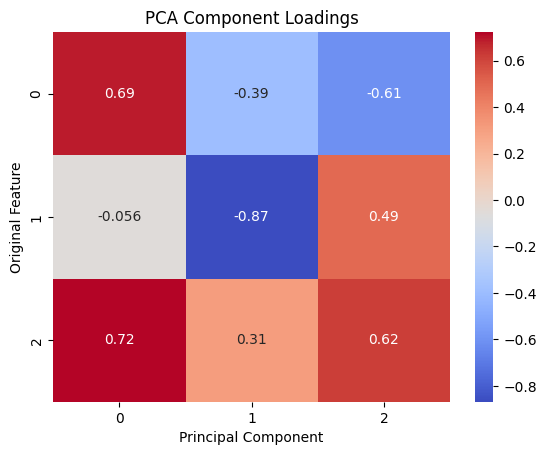

In [ ]:
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.xlabel('Principal Component')
plt.ylabel('Original Feature')
plt.title('PCA Component Loadings')
plt.show()

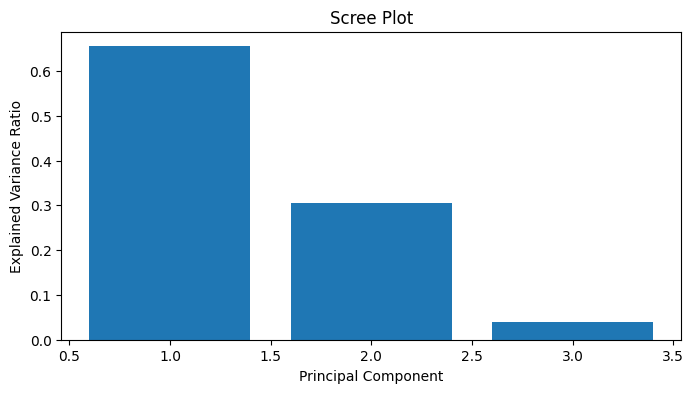

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

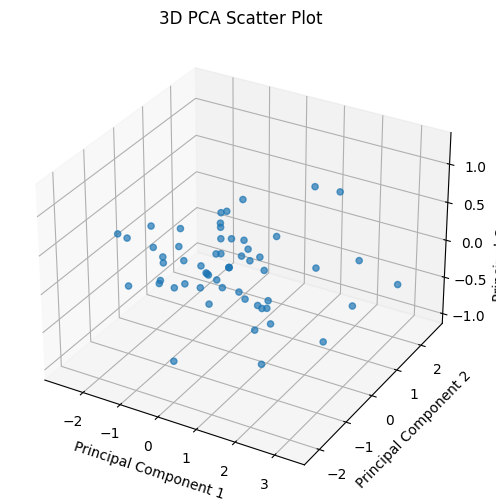

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], alpha=0.7)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Scatter Plot')

plt.show()

In [ ]:
import json

with open('correlation_results.json', 'w') as file:
    json.dump(correlation_results, file, indent=4)